# 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

### train 데이터셋 로드 및 확인

In [3]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 독립변수, 종속변수 분리 및 확인

In [5]:
x_train = train_df.iloc[:,2:] # 3번째 열 ~ 마지막 열
y_train = train_df['label']

display(x_train.head(3))
display(y_train.head(3))

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0


0    2
1    9
2    6
Name: label, dtype: int64

### 처음 4개의 이미지 출력

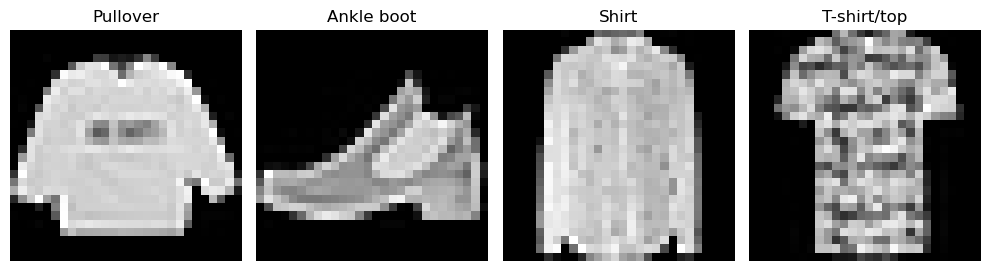

In [6]:
labels = y_train.values
images = x_train.values  # 픽셀 값만 가져옵니다

# 첫 4개의 이미지와 레이블 가져오기
num_images_to_show = 4
images_to_show = images[:num_images_to_show]
labels_to_show = labels[:num_images_to_show]

# 각 클래스의 이름
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 이미지 출력
plt.figure(figsize=(10, 4))
for i in range(num_images_to_show):
    img = images_to_show[i].reshape(28, 28)
    label = class_names[labels_to_show[i]]
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 훈련셋, 검증셋 분리

In [7]:
x_train = x_train.values
y_train = y_train.values

# train_test_split() -> 넘파이 배열 형태로 분리됨
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=24)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 784)
(12000, 784)
(48000,)
(12000,)


In [11]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
y_train

array([1, 8, 6, ..., 0, 6, 0], dtype=int64)

### 데이터셋 형태 변환 및 차원 확인  
왜 형태를 변환?  
Fashion MNIST 데이터셋의 원본은 (이미지 개수 N, 28, 28) 형태의 넘파이 배열.  
CNN은 채널 정보까지 포함된 4D 텐서 형태가 필요.  
=> (N, 28, 28)를 (N, 28, 28, 1)로 변경

In [12]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) # 채널 1 : 흑백
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_valid.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)


### 이미지 데이터의 차원 순서 변경  
TensorFlow/Keras: (N, H, W, C) → 채널(C)이 마지막  
PyTorch: (N, C, H, W) → 채널(C)이 두 번째  
Fashion MNIST처럼 (N, H, W, C)형태의 데이터를 (N, C, H, W)로 변환

In [13]:
x_train = x_train.transpose(0, 3, 1, 2)
x_valid = x_valid.transpose(0, 3, 1, 2)

print(x_train.shape)
print(x_valid.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


### numpy 배열을 tensor로 변환    
PyTorch에서는 데이터를 torch.Tensor 형식으로 변환해야 모델에 입력 가능

In [14]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)

### 커스텀 데이터셋 클래스 정의  
torchvision.datasets에 없는 데이터셋을 사용할 경우 필수적으로 만들어야 함    
이미 PyTorch 내장 데이터셋(torchvision.datasets.MNIST)을 사용한다면 필요 없음  
DataLoader가 CustomDataset을 사용하려면 __getitem__()과 __len__() 정의 필수

In [16]:
class CustomDataset(Dataset):
    # 데이터셋 초기화
    def __init__(self, images, labels=None, transform=None): 
        self.images = images
        self.labels = labels
        self.transform = transform
    
    # 특정 인덱스(idx)에 해당하는 데이터를 반환
    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image
    
    # 전체 데이터 크기 반환
    def __len__(self):
        return len(self.images)

### 데이터 전처리, 데이터셋 및 데이터 로더 정의  
PyTorch 기반 딥러닝 모델은 데이터를 불러올 때 Dataset과 DataLoader를 사용

In [17]:
# 이미지 데이터 전처리
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,)) # 정규화 (평균 0.5, 표준 편차 0.5)
])

# 데이터셋 정의
train_dataset = CustomDataset(x_train, y_train, transform=transform)
valid_dataset = CustomDataset(x_valid, y_valid, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

### 간단한 CNN 모델 정의

In [18]:
class SimpleCNN(nn.Module): # nn.Module을 상속받아 PyTorch의 신경망 구조를 따름
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # 레이어 정의
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # 순전파
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 모델 학습 및 검증 함수 정의

In [20]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=2):
    # 학습 루프
    for epoch in range(num_epochs): # 에포크
        model.train() # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct_train = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            
        # 에포크 손실 및 정확도 계산
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

        # 검증 루프
        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                
        # 검증 손실 및 정확도 계산
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

### 모델 초기화 및 학습 실행

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=2)

Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████| 750/750 [00:06<00:00, 107.80batch/s]


Epoch 1/2, Train Loss: 0.9252, Train Accuracy: 0.8332
Validation Loss: 0.3496, Validation Accuracy: 0.8683


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 250.51batch/s]


Epoch 2/2, Train Loss: 0.3128, Train Accuracy: 0.8849
Validation Loss: 0.3088, Validation Accuracy: 0.8843


### test 데이터 로드 및 데이터 로더 생성

In [22]:
test_df = pd.read_csv('data/test.csv')
x_test = test_df.iloc[:,1:].values # 2번째 열부터 (인덱스 제외)

# 채널(1) 추가하고 파이토치에 맞춰 순서 바꾸기
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).transpose(0, 3, 1, 2) 
# tensor로 변환
x_test = torch.tensor(x_test, dtype=torch.float32)

# 데이터셋, 데이터 로더
test_dataset = CustomDataset(x_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
test_df

,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,9996,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,9997,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,9998,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### test 데이터에 대한 예측 수행

In [24]:
model.eval() # 모델을 평가 모드로 설정
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        
predictions[:10]

[0, 1, 2, 6, 3, 6, 8, 6, 5, 0]

### 예측 결과를 제출 파일로 저장

In [ ]:
# submission = pd.read_csv('sample_submission.csv')

# submission['label'] = predictions
# submission.to_csv('submission.csv', index=False)